In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import clip
from PIL import Image
import clip
import numpy as np

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Load Model

In [3]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

Let's opt for simplicity and start with the smallest ResNet model (50)

In [4]:
name = 'RN50'
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

model, preprocess = clip.load(name, device=device, jit=False)

device: cpu


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa188572c10>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Load Data

## DataLoaders

In [6]:
from dataset import CocoCaseStudyDataset
from torch.utils.data import DataLoader
from torchvision import transforms

np.random.seed(0)

transform = transforms.Compose([
    transforms.Resize((224,224,)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

train_dataset = CocoCaseStudyDataset(split='train', experiment_type='few', transform=transform, 
                                     split_ratio=0.8)
val_dataset = CocoCaseStudyDataset(split='validation', experiment_type='few', transform=transform, 
                                  excluded_paths=train_dataset.get_data_paths())
test_dataset = CocoCaseStudyDataset(split='test', experiment_type='few', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
len(train_dataset), len(val_dataset), len(test_dataset)

(188, 46, 503)

## Visualize Inputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


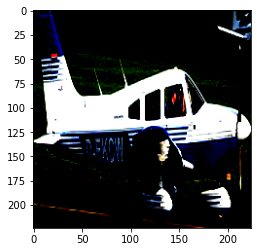

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


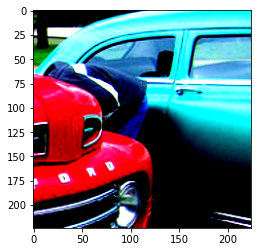

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


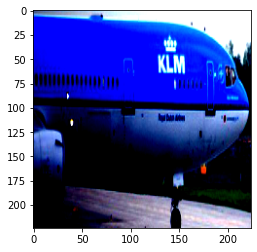

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


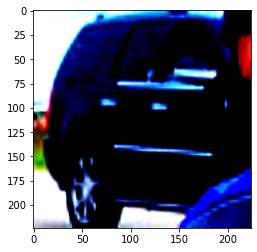

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


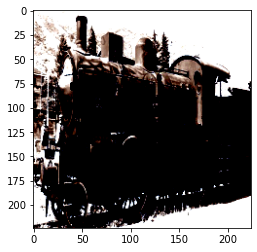

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


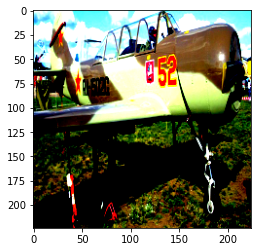

In [8]:
import matplotlib.pyplot as plt

# Transformed model inputs, not original pictures
# Important Note: Center crop that comes from the original transformation of the CLIP is replaced
# by resize method because we observed the objects in the current dataset can disappear due to center crop.

for batch_ndx, (image, cls) in enumerate(train_dataloader):
    plt.imshow(image[0].permute(1,2,0))
    plt.show()

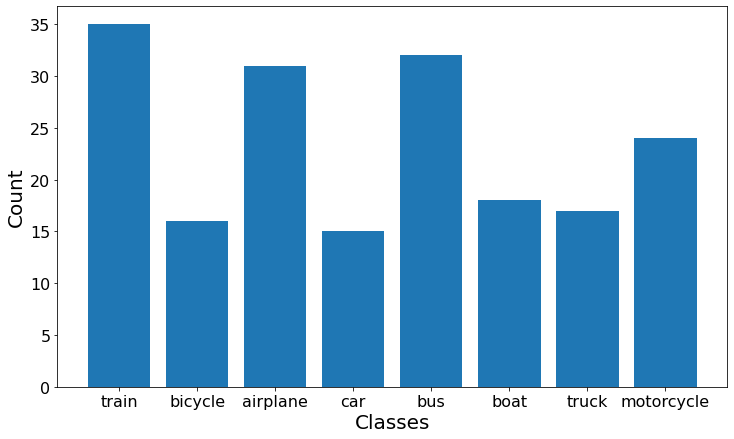

In [9]:
# Class Histograms

class_counts = train_dataset.get_class_counts()

plt.figure(figsize=(12,7))
plt.bar(class_counts.keys(), list(class_counts.values()))  # density=False would make counts
plt.ylabel('Count', fontsize=20)
plt.xlabel('Classes', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Training

In [10]:
training_encodings = []
training_classes = []

for batch_ndx, (image, cls) in enumerate(train_dataloader):
    training_encoded_img = model.encode_image(image).detach().cpu().numpy()
    training_encodings.append(training_encoded_img)
    training_classes += cls

training_encodings = np.concatenate(training_encodings,axis=0)
training_encodings.shape, len(training_classes)

((188, 1024), 188)

In [11]:
val_encodings = []
val_classes = []

for batch_ndx, (image, cls) in enumerate(val_dataloader):
    val_encoded_img = model.encode_image(image).detach().cpu().numpy()
    val_encodings.append(val_encoded_img)
    val_classes += cls

val_encodings = np.concatenate(val_encodings,axis=0)
val_encodings.shape, len(val_classes)

((46, 1024), 46)

## SVM

In [12]:
from sklearn.svm import SVC

gamma = [1e-2, 1e-1, 1e0, 1e+1, 'scale', 'auto']
C = [1e-3, 1e-2,1e-1,1e-0,1e+1,1e+2]

best = 0
final_gamma = None
final_C = None
best_svm_classifier = None

for gamma_val in gamma:
    for C_val in C:
        svm = SVC(gamma=gamma_val, C=C_val)
        svm.fit(training_encodings, training_classes)

        score = svm.score(val_encodings, val_classes)
        if score > best:
            best = score
            best_svm_classifier = svm
            final_gamma = gamma_val
            final_C = C_val
            
del svm
print(f'Best params: C is {final_C}, gamma is {final_gamma}')

Best params: C is 10.0, gamma is scale


In [13]:
# Training score
best_svm_classifier.score(training_encodings, training_classes)

1.0

## MLP

In [14]:
from sklearn.neural_network import MLPClassifier


lr = [1e-4,1e-3,5e-3,1e-2]
hidden_layer_sizes = [(32),(64),(128), (128,64), (64,32)]
solver = ['adam', 'sgd']
batch_size = [16,32,64]

best_lr = None
best_hidden_layer_sizes = None
best_solver = None
best_batch_size = None

best = 0
best_mlp_classifier = None

for lr_val in lr:
    for hidden_val in hidden_layer_sizes:
        for solver_val in solver:
            for batch_size_val in batch_size:
                
                mlp = MLPClassifier(
                    hidden_layer_sizes=hidden_val,
                    solver=solver_val,
                    batch_size=batch_size_val, 
                    learning_rate_init=lr_val
                )
                mlp.fit(training_encodings, training_classes)

                score = mlp.score(val_encodings, val_classes)
                if score > best:
                    best = score
                    best_mlp_classifier = mlp
                    
                    best_lr = lr_val
                    best_hidden_layer_sizes = hidden_val
                    best_solver = solver_val
                    best_batch_size = batch_size_val
            
del mlp
print(f"lr: {best_lr}, \n hidden layer size: {best_hidden_layer_sizes} \n solver: {best_solver} \n batch size: {best_batch_size}" 
    )

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/umur/anaco

lr: 0.005, 
 hidden layer size: 64 
 solver: adam 
 batch size: 16


/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
best_mlp_classifier.score(training_encodings, training_classes)

1.0

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

C = [1e-3, 1e-2,1e-1,5e-1,1e-0,1e+1,1e+2]
penalty = ['l1', 'l2']

best = 0
final_C = None
final_penalty = None
best_lr_classifier = None

for C_val in C:
    for penalty_val in penalty:
        lr = LogisticRegression(C=C_val, max_iter=1000, verbose=1)
        lr.fit(training_encodings, training_classes)

        score = lr.score(val_encodings, val_classes)
        if score > best:
            best = score
            best_lr_classifier = lr
            final_penalty = penalty_val
            final_C = C_val
            
del lr
print(f'Best params: C is {final_C}, penalty is {final_penalty}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90935D+02    |proj g|=  1.15000D+01

At iterate   50    f=  3.92656D+01    |proj g|=  9.57689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 8200     77     86      1     0     0   7.402D-04   3.927D+01
  F =   39.265179251922518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         8200     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.90935D+02    |proj g|=  1.15000D+01

At iterate   50  

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best params: C is 1.0, penalty is l1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


# Test

In [19]:
test_encodings = []
test_classes = []

for batch_ndx, (image, cls) in enumerate(test_dataloader):
    test_encoded_img = model.encode_image(image).detach().cpu().numpy()
    test_encodings.append(test_encoded_img)
    test_classes += cls

test_encodings = np.concatenate(test_encodings,axis=0)
test_encodings.shape, len(test_classes)

((503, 1024), 503)

In [20]:
svm_score = best_svm_classifier.score(test_encodings, test_classes)
svm_score

0.852882703777336

In [21]:
mlp_score = best_mlp_classifier.score(test_encodings, test_classes)
mlp_score

0.8687872763419483

In [22]:
lr_score = best_lr_classifier.score(test_encodings, test_classes)
lr_score

0.8330019880715706

### Accuracy

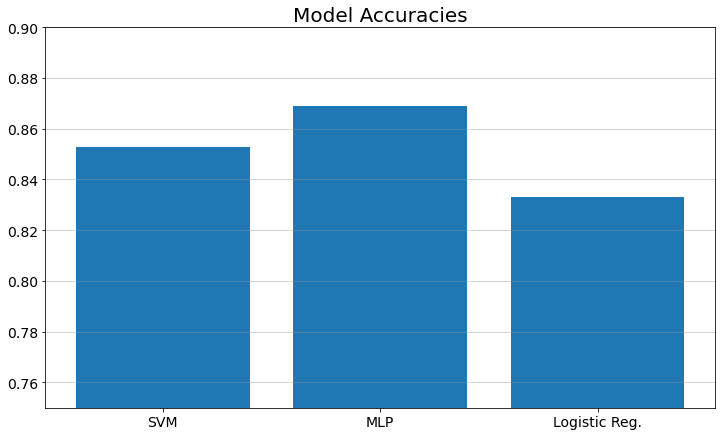

In [23]:
fig, ax = plt.subplots(figsize=(12,7))

ax.bar(['SVM', 'MLP', 'Logistic Reg.'],[svm_score, mlp_score, lr_score])
ax.set_ylim([0.75, 0.9])
ax.set_title('Model Accuracies',fontsize=20)

plt.xticks(fontsize=14)
plt.grid(axis='y', linestyle='-',alpha=0.5,color='#999999')
plt.yticks(fontsize=14)
plt.show()

### Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(
    y_true = test_classes,
    y_pred = best_mlp_classifier.predict(test_encodings),
    labels=np.unique(np.asarray(test_classes))
)

array([[60,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 42,  0,  0,  0,  4,  0,  0],
       [ 1,  0, 75,  0,  1,  1,  1,  0],
       [ 0,  0,  1, 64,  0,  0,  3,  1],
       [ 0,  0,  0,  1, 28,  0,  0, 18],
       [ 0,  2,  0,  0,  0, 52,  0,  0],
       [ 0,  0,  3,  2,  1,  0, 61,  0],
       [ 0,  0,  3, 17,  3,  3,  0, 55]])

/home/umur/anaconda3/envs/cs/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


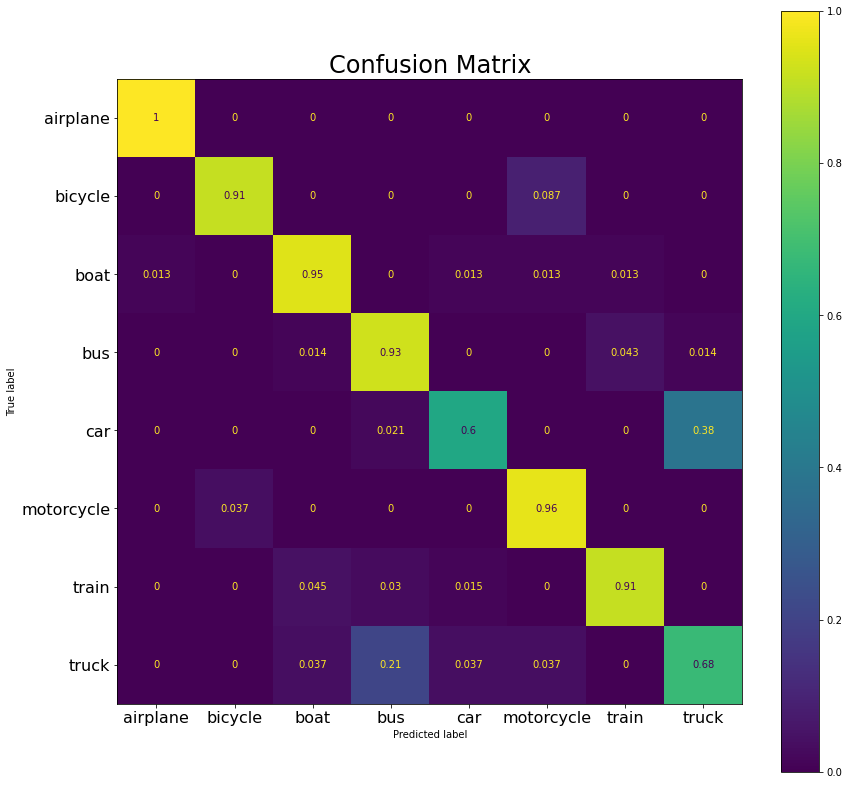

In [25]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(14, 14))
ts = 16
plt.xticks(fontsize=ts)
plt.yticks(fontsize=ts)
plt.title('Confusion Matrix', fontsize=24)

plot_confusion_matrix(
    best_mlp_classifier, 
    test_encodings, 
    test_classes,
    ax=ax,
    normalize='true'
)  
plt.show()

### Dimension Reduction

In [26]:
from sklearn.decomposition import PCA
pca = PCA(128)
training_embedded_encoding = pca.fit_transform(training_encodings)

np.sum(pca.explained_variance_ratio_)

0.9796004

In [27]:
test_embedded_encoding = pca.transform(test_encodings)

np.sum(pca.explained_variance_ratio_)

0.9796004

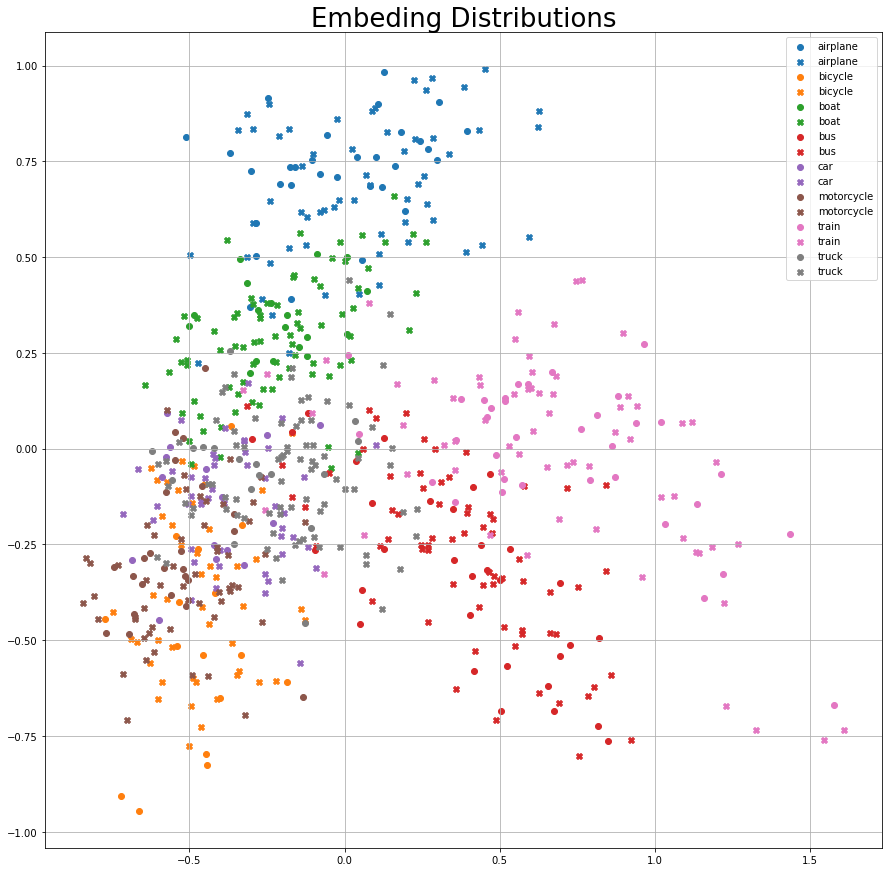

In [28]:
f, axs = plt.subplots(figsize=(15, 15))

train_classes = np.array(training_classes)
test_classes = np.array(test_classes)

colors = [f'C{i}' for i in range(len(set(train_classes)))]

for i, cls in enumerate(np.unique(np.array(train_classes))):
    training_cls_embedding = training_embedded_encoding[train_classes==cls]
    plt.scatter(training_cls_embedding[:, 0], training_cls_embedding[:, 1], label=cls, c=colors[i])
    
    test_cls_embedding = test_embedded_encoding[test_classes==cls]
    plt.scatter(test_cls_embedding[:, 0], test_cls_embedding[:, 1], label=cls, c=colors[i], marker='X')

plt.title('Embeding Distributions', fontsize=26)
plt.legend()
plt.grid()